# 4998 Applied Deep Learning Project
## Detect Cancer Metastases on Pathology Images

Jing Qian (jq2282)

# STEP 1. First glance of data and generate training images

## Step 1 is processed in GenerateTrain.ipynb.



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
total_path = '/content/drive/My Drive/project-adl'

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
input_size = 299 # in corresponding level
tumor_check_size = 128 # in level 0 with the highest resolution

# STEP 2. MODELING

* Although transfer learning may be less effective than training a model from scratch , it is the best place to start.
* Choose a model previously trained on Imagenet. Use the techniques in Chapter 5 of Francois’s book to try transfer learning (add a single Dense layer on top of that model), and train it on your own data.
* Write a script that takes your trained model and a testing image, and outputs a heat map showing the cancerous regions.
* Design an evaluation metric, write a script to report your results

加快速度，不看背景，只看tissue。比如对色彩做个threshold

选一个特别放大的开始做，比如800\*600 pixel图片
annotation. 选择哪部分有cancer

image segmentation, 


In [0]:
TARGET_SHAPE = 299
BATCH_SIZE = 32

## 2.0 Get Training Images

In [0]:
train_dir = 'drive/My Drive/project-adl/train_level4'

In [0]:
nclass=200

## 2.1 Transfer learning

In [47]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

conv_base = InceptionV3(weights='imagenet',include_top=False, input_shape=(299,299,3))
#conv_base.summary()
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048)) # get from conv_base.summary()
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)       
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, nclass*2)
print(train_labels)

FLATTENED_SHAPE = 8 * 8 * 2048


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


NameError: ignored

In [23]:
train_features = np.reshape(train_features, (nclass*2, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split = 0.2)

Train on 320 samples, validate on 80 samples
Epoch 1/50
320/320 [==============================] - 1s 4ms/sample - loss: 2.9683 - acc: 0.7406 - val_loss: 1.7289 - val_acc: 0.8875
Epoch 2/50
320/320 [==============================] - 1s 2ms/sample - loss: 2.4292 - acc: 0.8375 - val_loss: 1.3472 - val_acc: 0.9125
Epoch 3/50
320/320 [==============================] - 1s 2ms/sample - loss: 2.6834 - acc: 0.8281 - val_loss: 1.1755 - val_acc: 0.9250
Epoch 4/50
320/320 [==============================] - 1s 2ms/sample - loss: 2.3100 - acc: 0.8531 - val_loss: 1.5942 - val_acc: 0.9000
Epoch 5/50
320/320 [==============================] - 1s 2ms/sample - loss: 1.9793 - acc: 0.8719 - val_loss: 1.0008 - val_acc: 0.9375
Epoch 6/50
320/320 [==============================] - 1s 2ms/sample - loss: 2.6346 - acc: 0.8344 - val_loss: 1.1300 - val_acc: 0.9250
Epoch 7/50
320/320 [==============================] - 1s 2ms/sample - loss: 2.4059 - acc: 0.8469 - val_loss: 1.7164 - val_acc: 0.8875
Epoch 8/50
320/32

## 2.2 Train from scratch

In [0]:
conv_base_2 = InceptionV3(weights=None,include_top=False, input_shape=(299,299,3))
#conv_base_2.summary()
datagen = ImageDataGenerator(rescale=1./255)

def extract_features_2(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048)) # get from conv_base.summary()
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_2.predict(inputs_batch)       
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features_2(train_dir, nclass*2)
print(train_labels)

FLATTENED_SHAPE = 8 * 8 * 2048

In [0]:
train_features = np.reshape(train_features, (nclass*2, FLATTENED_SHAPE))
EPOCHS = 50
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split = 0.2)

# STEP 3. TEST!

### General Params

In [17]:
input_size = 299
tumor_check_size = 128
bound = (input_size - 1)/2

down_factor = dict()
for i in range(8):
  down_factor[i] = 2**i
print(down_factor)

{0: 1, 1: 2, 2: 4, 3: 8, 4: 16, 5: 32, 6: 64, 7: 128}


### Start with one slide

## 3.1. Generate testing image

In [0]:
# Paras
ilevel = 4
slide_id = '110'

In [8]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

# This function has nothing to do with tumor mask, but shows tissue region
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    #print('1')
    im = slide.read_region((x,y), level, (width, height))
    #print('2')
    im = im.convert('RGB') # drop the alpha channel
    #print('3')
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [11]:
slide_path = os.path.join(total_path,'slides/tumor_%s.tif' %slide_id)
tumor_mask_path = os.path.join(total_path,'slides/tumor_%s_mask.tif' %slide_id)

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    if i < 8:
      assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/drive/My Drive/project-adl/slides/tumor_110.tif with width: 94208, height: 71680
Read tumor mask from /content/drive/My Drive/project-adl/slides/tumor_110_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256


In [0]:
slide_image = read_slide(slide, 
                       x=0, 
                       y=0, 
                       level=ilevel, 
                       width=slide.level_dimensions[ilevel][0], 
                       height=slide.level_dimensions[ilevel][1])

In [0]:
# Abstract pathces from level 4, stride 64.
# 128*128 in level 4 corresponds to 64*64 in level 3, so stride 64.
# Like in training, cut the 10% border but without grayscale filters.
test = []
# slide_image is 3d, [height, width, channel]
stride = 64
nx = (int(slide.level_dimensions[ilevel][0]*0.9)-int(slide.level_dimensions[ilevel][0]*0.1))//stride
ny = (int(slide.level_dimensions[ilevel][1]*0.9)-int(slide.level_dimensions[ilevel][1]*0.1))//stride
for i in range(nx):
  for j in range(ny):
    patch_ij = read_slide(slide,
                          x = int((i*stride-bound)*down_factor[ilevel]),
                          y = int((j*stride-bound)*down_factor[ilevel]),
                          level = ilevel,
                          width = input_size,
                          height = input_size)
    test.append(patch_ij)

## 3.2. Save the testing images

In [6]:
import shutil
test_dir = 'drive/My Drive/project-adl/test_level%d' %ilevel
if not os.path.exists(test_dir):
  os.mkdir(test_dir)

NameError: ignored

(4088, 299, 299, 3)


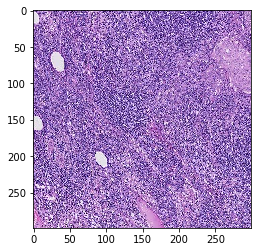

In [45]:
print(np.shape(test))
plt.imshow(test[1000])
from matplotlib.image import imsave
for i in range(nx):
  for j in range(ny):
    filename = os.path.join(test_dir, 'tumor_%s_cenx%d_ceny%d.png' 
                            %(slide_id, int(i*stride),int(j*stride)))
    imsave(filename, test[i*ny+j])

In [5]:
def extract_features_predict(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048)) # get from conv_base.summary()
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)       
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features
test_features = extract_features_predict(test_dir, 100)
model.predict(test_features, batch_size = 32)

NameError: ignored

## 3.2. Compare with the true labels

In [0]:
mask_image = read_slide(tumor_mask, 
                      x=0, 
                      y=0, 
                      level=7, 
                      width=slide.level_dimensions[7][0], 
                      height=slide.level_dimensions[7][1])[:,:,0]

NameError: ignored